In [1]:
import string
import re
import statistics
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [14]:
data = read_text("/Users/davidebonaglia/Dropbox/PhD NOTES/COURSES/Utretch Summer School/Thursday/nld-eng/nld.txt")
nld_eng = to_lines(data)
nld_eng = array(nld_eng)

In [15]:
### Here you see an example on how to use the maketrans() function ###
# specify the list of characters that need to be replaced
str1 = "mtex"

# specify the list of characters with which the characters need to be replaced
str2 = "dwoo"

# specify the list of characters that needs to be deleted
str3 = "u"

# target string 
temp_str = "text mining"

# using maketrans() to construct a translate table
table = temp_str.maketrans(str1, str2, str3)
  
# Printing original string 
print ("The string before translating is : ", end ="")
print (temp_str)
  
# using translate() to make translations.
print ("The string after translating is : ", end ="")
print (temp_str.translate(table))

The string before translating is : text mining
The string after translating is : woow dining


In [16]:
nld_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in nld_eng[:,0]]
nld_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in nld_eng[:,1]]

In [17]:
# convert to lowercase
for i in range(len(nld_eng)):
    nld_eng[i,0] = nld_eng[i,0].lower()    
    nld_eng[i,1] = nld_eng[i,1].lower()

In [18]:
nld_eng

array([['go', 'lopen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7764436 (LinguisticFusion)'],
       ['go', 'vooruit',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #7915821 (Elsofie)'],
       ['hi', 'hoi',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #537889 (Dorenda)'],
       ...,
       ['always use distilled water in steam irons because using ordinary water will cause a mineral buildup over time that will clog the steam holes',
        'gebruik altijd gedistilleerd water in stoomstrijkijzers want gewoon water zorgt voor mineraalophoping dat de stoomgaatjes na verloop van tijd verstopt',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3020388 (Delian) & #3037091 (Citrine)'],
       ['if you translate from your second language into your own native language rather than the other way around youre less likely to make mistakes',
        'als je vanuit je tweede taal naar je eigen moedertaal vertaalt in pla

In [19]:
# empty lists
eng_l = []
nld_l = []
# populate the lists with sentence lengths
for i in nld_eng[:,0]:
    eng_l.append(len(i.split()))

for i in nld_eng[:,1]:
    nld_l.append(len(i.split()))

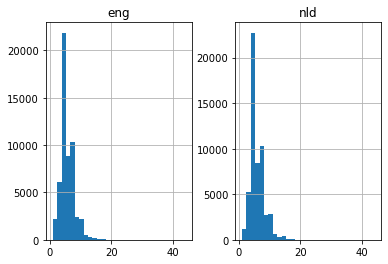

In [20]:
length_df = pd.DataFrame({'eng':eng_l, 'nld':nld_l})
length_df.hist(bins = 30)
plt.show()

In [21]:
train, test = train_test_split(nld_eng, test_size=0.2, random_state=321)

In [22]:
# prepare english tokenizer
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(nld_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 9073


In [23]:
# prepare Dutch tokenizer
nld_tokenizer = Tokenizer()
nld_tokenizer.fit_on_texts(nld_eng[:, 1])
nld_vocab_size = len(nld_tokenizer.word_index) + 1
print('Dutch Vocabulary Size: %d' % nld_vocab_size)
# print('Dutch Vocabulary Size:', nld_vocab_size)

Dutch Vocabulary Size: 12794


In [24]:
# encode and pad sequences
def encode_sequences(tokenizer, maximum_length, sentences):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(sentences)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=maximum_length, padding='post')
    return seq

In [25]:
eng_length = 40
nld_length = 40
# prepare training data
train_X = encode_sequences(nld_tokenizer, nld_length, train[:, 1])
train_Y = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [26]:
# prepare test data
test_X = encode_sequences(nld_tokenizer, nld_length, test[:, 1])
test_Y = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [27]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, embedding_size, LSTMunits):
    model = Sequential()
    model.add(Embedding(in_vocab, embedding_size, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(LSTMunits))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(LSTMunits, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [28]:
model = build_model(nld_vocab_size, 
                    eng_vocab_size, 
                    nld_length, 
                    eng_length, 
                    300, 
                    512)

In [29]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           3838200   
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1665024   
_________________________________________________________________
repeat_vector (RepeatVector) (None, 40, 512)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 512)           2099200   
_________________________________________________________________
dense (Dense)                (None, 40, 9073)          4654449   
Total params: 12,256,873
Trainable params: 12,256,873
Non-trainable params: 0
_________________________________________________________________


In [30]:
filename = 'model.15Epochs'
checkpoint = ModelCheckpoint(filename, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

history = model.fit(train_X, train_Y.reshape(train_Y.shape[0], train_Y.shape[1], 1),
                    epochs=15,
                    batch_size=128, 
                    validation_split = 0.2,
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/15
 34/275 [==>...........................] - ETA: 10:27 - loss: 1.8046 - accuracy: 0.8358

KeyboardInterrupt: 